In [26]:
"""
Baseline OLS (levels) — Train demand
------------------------------------
- Fits: Q = a + b*P + controls + error
- Controls: lead-time bins, calendar dummies, product-type dummies, customer segment, train fixed effects
- Robust (HC1) standard errors
- Saves a full summary table to baseline_ols_levels.txt
"""
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import os
import matplotlib.pyplot as plt

# 0) Load
IN_PATH = "/Users/utkarshtyagi/Documents/VSC/Dataset/Data-GP1.csv"
df = pd.read_csv(IN_PATH)
df.columns = [c.strip() for c in df.columns]

# 1) Helper: parse month-first strings -> datetime
def _parse_monthfirst_series(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.strip()
    out = pd.to_datetime(s, format='%m/%d/%y', errors='coerce')  # mm/dd/yy
    return out

# 2) Tell the script which columns are your dates
purch_col = 'Purchase_Date'
dept_col  = 'Dept_Date'

# 3) Parse dates (call the helper)
df[purch_col] = _parse_monthfirst_series(df[purch_col])
df[dept_col]  = _parse_monthfirst_series(df[dept_col])

# 4) Lead time (NOW you can use .dt)
df['days_to_departure'] = (df[dept_col] - df[purch_col]).dt.days

# 5) Calendar dummies
df['purchase_dow']    = df[purch_col].dt.dayofweek
df['purchase_month']  = df[purch_col].dt.month
df['departure_dow']   = df[dept_col].dt.dayofweek
df['departure_month'] = df[dept_col].dt.month

# 6) PRICE WINSORIZATION (0.5% & 99.5%)  ── [NEW]
def winsorize_series(s: pd.Series, lower_q: float = 0.005, upper_q: float = 0.995):
    lo, hi = s.quantile([lower_q, upper_q])
    return s.clip(lower=lo, upper=hi), float(lo), float(hi)

# pick the source price column you actually have
PRICE_SRC = "price" if "price" in df.columns else "mean_net_ticket_price"

if "price_winsor" not in df.columns:
    df["price_winsor"], p_lo, p_hi = winsorize_series(
        pd.to_numeric(df[PRICE_SRC], errors="coerce"), 0.005, 0.995
    )
    print(f"[OK] created price_winsor from '{PRICE_SRC}' with limits [{p_lo:.3f}, {p_hi:.3f}]")

# use the winsorized price for all jump-scan calcs
PRICE_COL = "price_winsor"
TRAIN_COL = "Train_Number_All"  # or "train_id" if you renamed earlier


# Keep sane rows
if 'mean_net_ticket_price' not in df.columns or 'num_seats_total' not in df.columns:
    raise ValueError("Expected columns 'mean_net_ticket_price' and 'num_seats_total' not found.")
df = df[(df['mean_net_ticket_price'] > 0) & (df['num_seats_total'] > 0)].copy()  
df = df[df['days_to_departure'].between(0, 365)].copy()

[OK] created price_winsor from 'mean_net_ticket_price' with limits [79.436, 694.479]


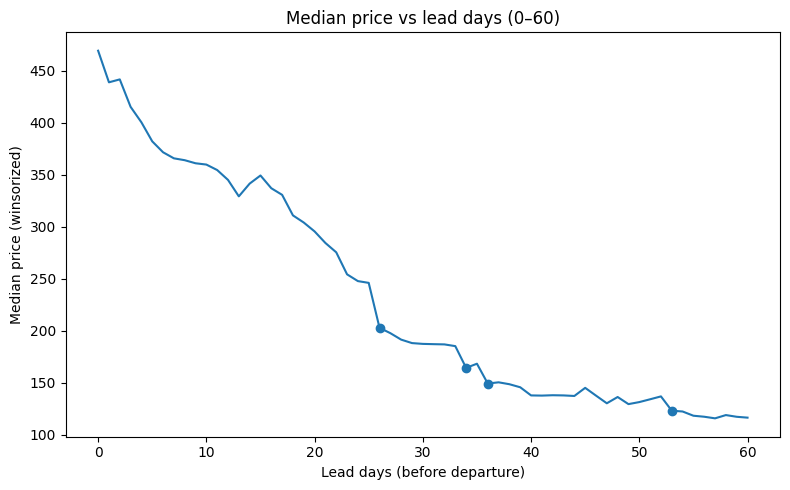

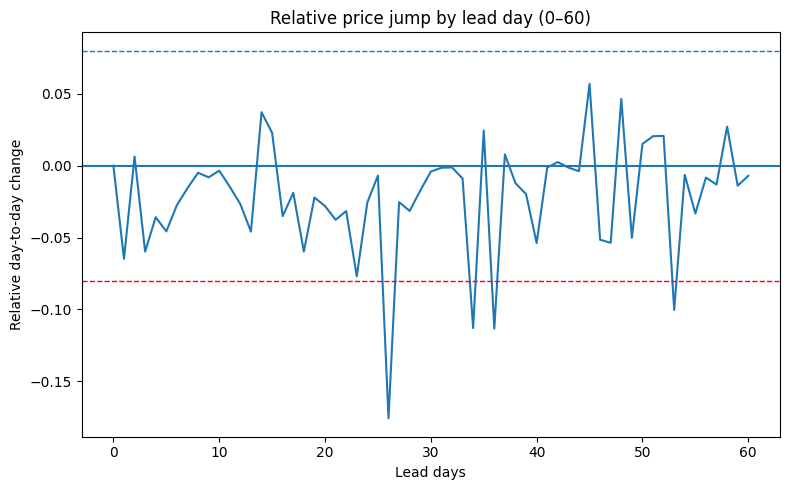

Saved figures to: /Users/utkarshtyagi/Documents/VSC/JumpScanResults


In [27]:
# ==============================================
# Lead-time jump scan using WINSORIZED price
# Outputs:
#   - overall_median_price_vs_leaddays_0to60.png
#   - overall_relative_jump_vs_leaddays_0to60.png
# ==============================================

from IPython import get_ipython
ip = get_ipython()
if ip is not None:
    ip.run_line_magic("matplotlib", "inline")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------- knobs --------
SCAN_MIN, SCAN_MAX = 0, 60          
FOCUS_MIN, FOCUS_MAX = 25, 35       
TOP_SHOW = 5                       

import os
OUTDIR = "/Users/utkarshtyagi/Documents/VSC/JumpScanResults"
os.makedirs(OUTDIR, exist_ok=True)

# -------- jump detectors (use winsorized price) --------
def detect_jumps_overall(frame: pd.DataFrame,
                         price_col: str = PRICE_COL,
                         rel_threshold=0.08,
                         min_obs: int = 50) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Median winsorized price by exact lead_day; flag ≥threshold relative jumps with min obs on both sides."""
    overall = (frame.groupby('days_to_departure', as_index=False)
                     .agg(median_price=(price_col, 'median'),
                          n_obs=(price_col, 'size'))
                     .rename(columns={'days_to_departure': 'lead_days'})
                     .sort_values('lead_days'))
    overall['median_prev'] = overall['median_price'].shift(1)
    overall['rel_jump'] = (overall['median_price'] - overall['median_prev']) / overall['median_prev']
    overall['is_candidate'] = (
        overall['rel_jump'].abs() >= rel_threshold
    ) & (
        (overall['n_obs'] >= min_obs) & (overall['n_obs'].shift(1) >= min_obs)
    )
    return overall, overall.loc[overall['is_candidate']].copy()

def detect_jumps_per_train(frame: pd.DataFrame,
                           price_col: str = PRICE_COL,
                           train_col: str = TRAIN_COL,
                           rel_threshold=0.08,
                           min_obs: int = 10) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Per-train medians (winsorized), candidate jumps, and support count (how many trains jump at a given day ±1)."""
    if train_col not in frame.columns:
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

    g = (frame.groupby([train_col, 'days_to_departure'], as_index=False)
               .agg(median_price=(price_col, 'median'),
                    n_obs=(price_col, 'size'))
               .rename(columns={'days_to_departure': 'lead_days'})
               .sort_values([train_col, 'lead_days']))
    g['median_prev'] = g.groupby(train_col)['median_price'].shift(1)
    g['prev_n_obs']  = g.groupby(train_col)['n_obs'].shift(1)
    g['rel_jump'] = (g['median_price'] - g['median_prev']) / g['median_prev']
    g['is_candidate'] = (
        g['rel_jump'].abs() >= rel_threshold
    ) & (
        (g['n_obs'] >= min_obs) & (g['prev_n_obs'] >= min_obs)
    )
    pertrain_cands = g.loc[g['is_candidate']].copy()

    # support table (±1 day tolerance)
    rows = []
    if not pertrain_cands.empty:
        for d in np.sort(pertrain_cands['lead_days'].unique()):
            win = pertrain_cands[np.abs(pertrain_cands['lead_days'] - d) <= 1]
            rows.append({
                'lead_day': int(d),
                'num_trains_with_jump': int(win[train_col].nunique()),
                'avg_rel_jump': float(win['rel_jump'].mean())
            })
    support = (pd.DataFrame(rows)
                 .sort_values(['num_trains_with_jump', 'lead_day'],
                              ascending=[False, True]))
    return g, pertrain_cands, support

# -------- plotting (winsorized) --------
def plot_overall_curves(overall: pd.DataFrame,
                        overall_cands: pd.DataFrame,
                        xmax: int = 60,
                        save: bool = True,
                        outdir: str = OUTDIR,
                        rel_threshold=0.08):

    overall_short = overall[overall['lead_days'].between(0, xmax)].copy()
    cands_short   = overall_cands[overall_cands['lead_days'].between(0, xmax)].copy()

    # Fig 1: median price (winsorized) vs lead days
    plt.figure(figsize=(8, 5))
    plt.plot(overall_short['lead_days'], overall_short['median_price'])
    if not cands_short.empty:
        plt.scatter(cands_short['lead_days'], cands_short['median_price'])
    plt.xlabel("Lead days (before departure)")
    plt.ylabel("Median price (winsorized)")
    plt.title(f"Median price vs lead days (0–{xmax})")
    plt.tight_layout()
    if save:
        os.makedirs(outdir, exist_ok=True)
        plt.savefig(f"{outdir}/overall_median_price_vs_leaddays_0to{xmax}.png", dpi=150)
    plt.show()
    plt.close()

    # Fig 2: relative day-to-day change (based on winsorized medians)
    plt.figure(figsize=(8, 5))
    plt.plot(overall_short['lead_days'], overall_short['rel_jump'].fillna(0.0))
    plt.axhline(0.0)
    plt.axhline(+rel_threshold, linestyle='--', linewidth=1)
    plt.axhline(-rel_threshold, linestyle='--', linewidth=1, color='red')
    plt.xlabel("Lead days")
    plt.ylabel("Relative day-to-day change")
    plt.title(f"Relative price jump by lead day (0–{xmax})")
    plt.tight_layout()
    if save:
        plt.savefig(f"{outdir}/overall_relative_jump_vs_leaddays_0to{xmax}.png", dpi=150)
    plt.show()
    plt.close()

# ---------- RUN on 0..60 only ----------
scan = df[df['days_to_departure'].between(SCAN_MIN, SCAN_MAX)].copy()

overall, overall_cands = detect_jumps_overall(
    scan, price_col=PRICE_COL, rel_threshold=0.08, min_obs=50
)
# per-train scan (optional, not plotted here)
pertrain_curves, pertrain_cands, support = detect_jumps_per_train(
    scan, price_col=PRICE_COL, train_col=TRAIN_COL, rel_threshold=0.08, min_obs=10
)

# ---------- PLOTS (0..60) ----------
plot_overall_curves(overall, overall_cands, xmax=60, save=True, outdir=OUTDIR, rel_threshold=0.08)
print(f"Saved figures to: {OUTDIR}")

In [28]:
# ==========================================================
# PART 3 — PRINT diagnostics using WINSORIZED price
#   (assumes: df, scan, overall, overall_cands, support,
#             PRICE_COL="price_winsor", TRAIN_COL, OUTDIR,
#             FOCUS_MIN/FOCUS_MAX/TOP_SHOW already defined)
# ==========================================================

# (1) Cross-train frequency (support table)
if 'support' in locals() and not support.empty:
    sup = support.copy()
    sup["avg_rel_jump(%)"] = 100 * sup["avg_rel_jump"]
    sup = sup[["lead_day", "num_trains_with_jump", "avg_rel_jump(%)"]].round(2)

    print("\n[Cross-train cutoff frequency (0–60, ±1 day) — Top 5]")
    print(sup.head(TOP_SHOW).to_string(index=False))
else:
    print("\n[Cross-train cutoff frequency] No candidates in 0–60 window.")

# (2) Largest pooled price steps (overall candidates)
if 'overall_cands' in locals() and not overall_cands.empty:
    tmp = overall_cands.copy()
    tmp["jump_pct"] = 100 * tmp["rel_jump"]
    tmp = tmp.reindex(tmp["rel_jump"].abs().sort_values(ascending=False).index)

    print("\n[Largest pooled price steps (0–60) — Top 5]")
    print(
        tmp.loc[:, ["lead_days", "median_price", "n_obs", "jump_pct", "rel_jump"]]
           .round({"median_price": 2, "jump_pct": 1, "rel_jump": 4})
           .head(TOP_SHOW)
           .to_string(index=False)
    )
else:
    print("\n[Largest pooled price steps] None in 0–60 window.")

# (3) Per-train table for the focus window (uses winsorized price)
if TRAIN_COL in scan.columns:
    # build medians and day-to-day jumps over 0..60, then slice focus window
    focus_full = (
        scan.groupby([TRAIN_COL, "days_to_departure"], as_index=False)
            .agg(median_price=(PRICE_COL, "median"),
                 n_obs=(PRICE_COL, "size"))
            .rename(columns={"days_to_departure": "lead_days"})
            .sort_values([TRAIN_COL, "lead_days"])
    )
    focus_full["median_prev"] = focus_full.groupby(TRAIN_COL)["median_price"].shift(1)
    focus_full["rel_jump"]    = (focus_full["median_price"] - focus_full["median_prev"]) / focus_full["median_prev"]
    focus_full["jump_pct"]    = 100 * focus_full["rel_jump"]

    focus = focus_full[focus_full["lead_days"].between(FOCUS_MIN, FOCUS_MAX)].copy()

    print(f"\n[Per-train lead days {FOCUS_MIN}–{FOCUS_MAX} — median price (winsorized) & jump rate (%)]")
    if focus.empty:
        print("No rows in this window.")
    else:
        cols = [TRAIN_COL, "lead_days", "median_price", "n_obs", "jump_pct", "rel_jump"]
        print(
            focus[cols]
            .round({"median_price": 2, "jump_pct": 1, "rel_jump": 4})
            .to_string(index=False)
        )
        # optional: save the focus table
        focus_path = os.path.join(OUTDIR, f"pertrain_{FOCUS_MIN}_{FOCUS_MAX}_winsorized.csv")
        focus[cols].to_csv(focus_path, index=False)
        print("Saved focus table to:", focus_path)
else:
    print(f"\n[Per-train {FOCUS_MIN}–{FOCUS_MAX}] Column '{TRAIN_COL}' not found; skipped.")


[Cross-train cutoff frequency (0–60, ±1 day) — Top 5]
 lead_day  num_trains_with_jump  avg_rel_jump(%)
       20                    12           -11.00
       22                    12           -11.23
       34                    12            -7.28
       24                    11            -2.19
       25                    11            -7.45

[Largest pooled price steps (0–60) — Top 5]
 lead_days  median_price  n_obs  jump_pct  rel_jump
        26        202.72   1945     -17.6   -0.1758
        36        149.14   1636     -11.3   -0.1134
        34        164.20   1700     -11.3   -0.1130
        53        123.05   1179     -10.0   -0.1004

[Per-train lead days 25–35 — median price (winsorized) & jump rate (%)]
Train_Number_All  lead_days  median_price  n_obs  jump_pct  rel_jump
               A         25        247.60    139      24.3    0.2430
               A         26        205.60    123     -17.0   -0.1696
               A         27        198.64    108      -3.4   -0.03

In [29]:
# =========================================================
# PART 4 — Lead-time bins + LOG–LOG sample (winsorized P)
#   assumes df already has:
#     - days_to_departure, Purchase_Date, Dept_Date
#     - isOneway, isReturn, isNormCabin, Train_Number_All, Customer_Cat
#     - price_winsor  (create earlier with winsorize_series if missing)
# =========================================================

# ---- 1) Lead-time bins (same cutoffs as before) ----
bins_ext   = [0, 1, 2, 3, 6, 15, 25, 30, 35, 45, 60, 90, 120, np.inf]
labels_ext = ["(0,1]","(1,2]","(2,3]","(3,6]","(6,15]","(15,25]","(25,30]",
              "(30,35]","(35,45]","(45,60]","(60,90]","(90,120]",">120"]
df["lead_bin"] = pd.cut(
    df["days_to_departure"], bins=bins_ext, labels=labels_ext,
    right=True, include_lowest=True
).astype("category")

# ---- 2) Build LOG variables — use WINSORIZED price ----
# ensure a winsorized price exists
if "price_winsor" not in df.columns:
    # fall back gracefully if user forgot to create it
    PRICE_SRC = "price" if "price" in df.columns else "mean_net_ticket_price"
    df["price_winsor"], _, _ = winsorize_series(pd.to_numeric(df[PRICE_SRC], errors="coerce"))

df_log = df.copy()

# keep only rows safe for logs
mask_pos = (pd.to_numeric(df_log["num_seats_total"], errors="coerce") > 0) & \
           (pd.to_numeric(df_log["price_winsor"],     errors="coerce") > 0)
df_log = df_log.loc[mask_pos].copy()

# logs
df_log["ln_Q"] = np.log(df_log["num_seats_total"])
df_log["ln_P"] = np.log(df_log["price_winsor"])      # <<< CHANGED: winsorized price

# === Two-way clustering keys ===================================================
# departure_id = Train_Number_All x departure DATE (not datetime)               
if 'Train_Number_All' not in df_log.columns:
    raise ValueError("Expected column 'Train_Number_All' for FEs and clustering.")
df_log['departure_date_only'] = df_log[dept_col].dt.date                        
df_log['purchase_date_only']  = df_log[purch_col].dt.date                         
df_log['departure_id'] = (df_log['Train_Number_All'].astype(str) + '|' +
                          pd.Series(df_log['departure_date_only']).astype(str))    
# compact integer codes for clustering
df_log['departure_id_code']   = df_log['departure_id'].astype('category').cat.codes    
df_log['purchase_date_code']  = df_log['purchase_date_only'].astype('category').cat.codes

# --- Supply/competition frequency (time-varying) ------------------------------
df_log['same_day_freq'] = df_log.groupby(['departure_date_only'])['Train_Number_All'] \
    .transform('nunique')

df_log['ln_same_day_freq'] = np.log(df_log['same_day_freq'])


# Ensure clean 0/1 binaries (no row drop)
for c in ["isReturn", "isOneway"]:
    df_log[c] = (pd.to_numeric(df_log[c], errors="coerce")
                   .fillna(0).clip(0, 1).astype(int))

# Crosstab in your preferred semantics: rows=isReturn (0=leaving A, 1=back to A),
# columns=isOneway (0=round-trip ticket, 1=one-way ticket)
print("\n[Trip-type crosstab] rows=isReturn, cols=isOneway")
print(pd.crosstab(df_log["isReturn"], df_log["isOneway"]))

# Friendly 4-way label (for summaries/plots; not required for the regression)
conditions = [
    (df_log["isReturn"]==0) & (df_log["isOneway"]==0),  # RT outbound (leaving A on RT)
    (df_log["isReturn"]==1) & (df_log["isOneway"]==0),  # RT inbound  (back to A on RT)
    (df_log["isReturn"]==0) & (df_log["isOneway"]==1),  # OW outbound (leaving A on OW)
    (df_log["isReturn"]==1) & (df_log["isOneway"]==1),  # OW inbound  (back to A on OW)
]
choices = ["RT_outbound", "RT_inbound", "OW_outbound", "OW_inbound"]

# Convert to a pandas Series FIRST, then to category
df_log["trip_leg_type"] = pd.Series(
    np.select(conditions, choices, default="unknown"),
    index=df_log.index
).astype("category")

print(df_log["trip_leg_type"].value_counts(dropna=False))


# ---- Metadata (optional) --------------------------------
nrows      = len(df_log)
n_trains   = df_log["Train_Number_All"].nunique()
n_customer = df_log["Customer_Cat"].nunique() if "Customer_Cat" in df_log.columns else 0
print(f"[LOG sample] rows={nrows}, trains={n_trains}, customer segs={n_customer}")


[Trip-type crosstab] rows=isReturn, cols=isOneway
isOneway      0      1
isReturn              
0         91521  17483
1         92410   8283
trip_leg_type
RT_inbound     92410
RT_outbound    91521
OW_outbound    17483
OW_inbound      8283
Name: count, dtype: int64
[LOG sample] rows=209697, trains=15, customer segs=2


In [30]:
# ----------------- Controls W (no ticket terms here) -----------------
W_terms = 'C(lead_bin) + C(departure_dow) + C(departure_month)'

# Cabin & segment (unchanged)
if 'isNormCabin' in df_log.columns:
    W_terms += ' + C(isNormCabin)'
if 'Customer_Cat' in df_log.columns:
    W_terms += ' + C(Customer_Cat)'

# Train fixed effects if present
if 'Train_Number_All' in df_log.columns and n_trains > 1:
    W_terms += ' + C(Train_Number_All)'

# Adding Daily Frequency Control
W_terms = W_terms  

# ----------------- Ticket terms (keep both binaries) -----------------
USE_INTERACTION = False   # set True if you want 4-cell flexibility
ticket_terms = 'isOneway' + (' + isOneway:' if USE_INTERACTION else '')

# ----------------- Log–log OLS (elasticity model) -------------------
formula = f'ln_Q ~ ln_P + {ticket_terms} + {W_terms}'

# ---- Fit with TWO-WAY CLUSTERED SE ---------------------------------
clusters_2way_array = np.column_stack([
    df_log['departure_id_code'].to_numpy(),
    df_log['purchase_date_code'].to_numpy()
])

res = smf.ols(formula, data=df_log).fit(
    cov_type="cluster",
    cov_kwds={"groups": clusters_2way_array, "use_c": True}
)
cluster_note = "two-way (departure_id, purchase_date)"

print("\n=== OLS (log–log) with two-way clustered SEs ===")
print("Clustering:", cluster_note)
print(res.summary())

# quick read-outs
for k in ["ln_P", "isOneway", "isOneway:"]:
    if k in res.params:
        print(f"{k:16s}: {res.params[k]: .4f}  (SE={res.bse[k]:.4f}, p={res.pvalues[k]:.3f})")


=== OLS (log–log) with two-way clustered SEs ===
Clustering: two-way (departure_id, purchase_date)
                            OLS Regression Results                            
Dep. Variable:                   ln_Q   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     881.9
Date:                Sat, 20 Sep 2025   Prob (F-statistic):               0.00
Time:                        16:09:09   Log-Likelihood:            -1.9287e+05
No. Observations:              209697   AIC:                         3.858e+05
Df Residuals:                  209649   BIC:                         3.863e+05
Df Model:                          47                                         
Covariance Type:              cluster                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------

=== MODEL DIAGNOSTICS ===
Model formula: ln_Q ~ ln_P + isOneway + C(lead_bin) + C(departure_dow) + C(departure_month) + C(isNormCabin) + C(Customer_Cat) + C(Train_Number_All)
Model parameters: ['Intercept', 'C(lead_bin)[T.(1,2]]', 'C(lead_bin)[T.(2,3]]', 'C(lead_bin)[T.(3,6]]', 'C(lead_bin)[T.(6,15]]', 'C(lead_bin)[T.(15,25]]', 'C(lead_bin)[T.(25,30]]', 'C(lead_bin)[T.(30,35]]', 'C(lead_bin)[T.(35,45]]', 'C(lead_bin)[T.(45,60]]', 'C(lead_bin)[T.(60,90]]', 'C(lead_bin)[T.(90,120]]', 'C(lead_bin)[T.>120]', 'C(departure_dow)[T.1]', 'C(departure_dow)[T.2]', 'C(departure_dow)[T.3]', 'C(departure_dow)[T.4]', 'C(departure_dow)[T.5]', 'C(departure_dow)[T.6]', 'C(departure_month)[T.2]', 'C(departure_month)[T.3]', 'C(departure_month)[T.4]', 'C(departure_month)[T.5]', 'C(departure_month)[T.6]', 'C(departure_month)[T.7]', 'C(departure_month)[T.8]', 'C(departure_month)[T.9]', 'C(departure_month)[T.10]', 'C(departure_month)[T.11]', 'C(departure_month)[T.12]', 'C(isNormCabin)[T.1]', 'C(Customer_Cat)[

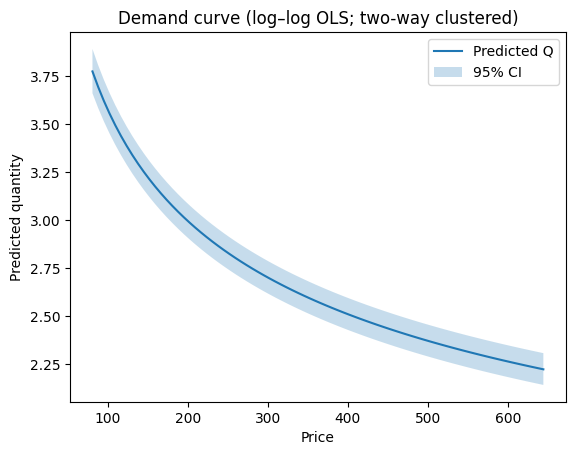


=== Fixed Effects (each level relative to its baseline) ===

[lead_bin]
   level  is_baseline    coef     se       t     p
   (0,1]         True  0.0000    NaN     NaN   NaN
   (1,2]         True  0.0000    NaN     NaN   NaN
 (15,25]         True  0.0000    NaN     NaN   NaN
   (2,3]         True  0.0000    NaN     NaN   NaN
 (25,30]         True  0.0000    NaN     NaN   NaN
   (3,6]         True  0.0000    NaN     NaN   NaN
 (30,35]         True  0.0000    NaN     NaN   NaN
 (35,45]         True  0.0000    NaN     NaN   NaN
 (45,60]         True  0.0000    NaN     NaN   NaN
  (6,15]         True  0.0000    NaN     NaN   NaN
 (60,90]         True  0.0000    NaN     NaN   NaN
(90,120]         True  0.0000    NaN     NaN   NaN
    (1,2        False  0.0105 0.0137   0.764 0.445
  (15,25        False -0.1306 0.0138  -9.494 0.000
    (2,3        False  0.0318 0.0168   1.894 0.058
  (25,30        False -0.1738 0.0152 -11.405 0.000
    (3,6        False  0.1240 0.0148   8.375 0.000
  (30,35 

In [31]:
# ==========================================================
# Final equation text + demand curve + Fixed-Effects tables
# (run AFTER you have: res, df_log, and your final formula)
# ==========================================================

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

# ---------- output folder ----------
try:
    OUT_DIR
except NameError:
    try:
        OUT_DIR = Path(IN_PATH).with_name("train_demand_outputs")
    except Exception:
        OUT_DIR = Path.cwd() / "train_demand_outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# First, let's check what's actually in your model
print("=== MODEL DIAGNOSTICS ===")
print(f"Model formula: {res.model.formula}")
print(f"Model parameters: {list(res.params.index)}")

# Check if ln_same_day_freq is in the model - we need to handle this
has_ln_same_day = 'ln_same_day_freq' in res.params.index
print(f"ln_same_day_freq in model: {has_ln_same_day}")

if has_ln_same_day:
    print("❌ WARNING: ln_same_day_freq is still in your model!")
    print("You need to re-run your regression without ln_same_day_freq")
    print("This analysis will proceed but results may be unreliable")

# ---------- pretty equation ----------
def print_demand_equation(res, df_log, use_interaction=None,
                          lead_col="lead_bin", dow_col="departure_dow",
                          mon_col="departure_month"):
    if use_interaction is None:
        use_interaction = ("isOneway:isReturn" in res.params.index)

    train_col = "train_id" if "train_id" in df_log.columns else (
                "Train_Number_All" if "Train_Number_All" in df_log.columns else None)
    cust_col  = "cust_cat" if "cust_cat" in df_log.columns else (
                "Customer_Cat" if "Customer_Cat" in df_log.columns else None)

    a    = res.params.get("Intercept", np.nan)
    b    = res.params.get("ln_P", np.nan)
    gow  = res.params.get("isOneway", np.nan)
    gret = res.params.get("isReturn", np.nan)
    gint = res.params.get("isOneway:isReturn", None) if use_interaction else None

    def base_of(col):
        if col and col in df_log.columns:
            s = df_log[col]
            try:
                return s.mode().iat[0]
            except Exception:
                return None
        return None

    base_lead = base_of(lead_col)
    base_dow  = base_of(dow_col)
    base_mon  = base_of(mon_col)
    base_trn  = base_of(train_col)
    base_cus  = base_of(cust_col)

    parts = [f"{a:.6f}", f"({b:.6f})*ln(P)", f"({gow:.6f})*isOneway", f"({gret:.6f})*isReturn"]
    if use_interaction and (gint is not None): 
        parts.append(f"({gint:.6f})*isOneway:isReturn")
    parts.append("FE(lead_bin, dep_dow, dep_month"
                 + (", Train" if train_col else "")
                 + (", Customer" if cust_col else "") + ")")

    txt = []
    txt.append("=== Estimated demand function (log–log) ===")
    txt.append(f"Baselines: lead_bin='{base_lead}', dep_dow={base_dow}, dep_month={base_mon}"
               + (f", Train='{base_trn}'" if base_trn is not None else "")
               + (f", Customer='{base_cus}'" if base_cus is not None else "") + ".")
    txt.append("ln(Q) = " + " + ".join(parts))
    full_text = "\n".join(txt)
    print("\n" + full_text + "\n")
    (OUT_DIR / "estimated_demand_function.txt").write_text(full_text, encoding="utf-8")
    return use_interaction

# print the equation
USE_INTERACTION = print_demand_equation(res, df_log)

# ---------- demand curve (levels) with 95% CI ----------
# Duan smearing back-transform
SMEAR = float(np.exp(res.resid).mean())

# resolve names possibly used
train_col = "train_id" if "train_id" in df_log.columns else (
            "Train_Number_All" if "Train_Number_All" in df_log.columns else None)
cust_col  = "cust_cat" if "cust_cat" in df_log.columns else (
            "Customer_Cat" if "Customer_Cat" in df_log.columns else None)

# hold covariates at typical values
base = {
    "isOneway": int(df_log["isOneway"].mode().iat[0]) if "isOneway" in df_log else 0,
    "isReturn": int(df_log["isReturn"].mode().iat[0]) if "isReturn" in df_log else 0,
    "isNormCabin": int(df_log["isNormCabin"].mode().iat[0]) if "isNormCabin" in df_log else 0,
    "lead_bin": df_log["lead_bin"].mode().iat[0] if "lead_bin" in df_log else None,
    "departure_dow": df_log["departure_dow"].mode().iat[0] if "departure_dow" in df_log else None,
    "departure_month": df_log["departure_month"].mode().iat[0] if "departure_month" in df_log else None,
    train_col: df_log[train_col].mode().iat[0] if train_col else None,
    cust_col:  df_log[cust_col].mode().iat[0]  if cust_col  else None,
}

# price grid on winsorized support
if "price_winsor" not in df_log.columns:
    raise KeyError("Expected 'price_winsor' in df_log for prediction grid.")
p1, p99 = df_log["price_winsor"].quantile([0.01, 0.99])
price_grid = np.linspace(float(p1), float(p99), 80)

# exog for prediction - CAREFULLY construct based on actual model variables
exog = pd.DataFrame({"ln_P": np.log(price_grid)})

# Only include variables that are actually in the model parameters
model_vars_in_data = []
for var in res.params.index:
    if var not in ['Intercept', 'ln_P', 'isOneway', 'isReturn', 'isOneway:isReturn'] and not var.startswith('C('):
        # This might be ln_same_day_freq or other variables
        if var in df_log.columns:
            model_vars_in_data.append(var)
            exog[var] = base.get(var, 0)  # Use base value or default

# Add the standard variables that are definitely in the model
for k in ["isOneway", "isReturn", "isNormCabin", "lead_bin", "departure_dow", "departure_month"]:
    if k in df_log.columns and k not in exog.columns:
        exog[k] = base[k]

if train_col and train_col not in exog.columns: 
    exog[train_col] = base[train_col]
if cust_col and cust_col not in exog.columns: 
    exog[cust_col] = base[cust_col]
if USE_INTERACTION:
    exog["isOneway:isReturn"] = base["isOneway"] * base["isReturn"]

print(f"Variables used for prediction: {list(exog.columns)}")

try:
    pred = res.get_prediction(exog=exog).summary_frame(alpha=0.05)
    Q_hat = np.exp(pred["mean"]) * SMEAR
    Q_lo  = np.exp(pred["mean_ci_lower"]) * SMEAR
    Q_hi  = np.exp(pred["mean_ci_upper"]) * SMEAR

    fig, ax = plt.subplots()
    ax.plot(price_grid, Q_hat, label="Predicted Q")
    ax.fill_between(price_grid, Q_lo, Q_hi, alpha=0.25, label="95% CI")
    ax.set_xlabel("Price")
    ax.set_ylabel("Predicted quantity")
    ax.set_title("Demand curve (log–log OLS; two-way clustered)")
    ax.legend()
    fig.savefig(OUT_DIR / "demand_curve_levels.png", dpi=150, bbox_inches="tight")
    plt.show()
    
except Exception as e:
    print(f"❌ Error in prediction: {e}")
    print("This is likely because ln_same_day_freq is still in your model")
    print("You need to re-run your regression without ln_same_day_freq")

# ---------- Fixed Effects: line-by-line table ----------
import re

def extract_fe_table(res, df, fe_vars):
    """
    Build a tidy FE table with one row per level (incl. baseline=0).
    Columns: fe_var, level, is_baseline, coef, se, t, p
    """
    rows = []
    for var in fe_vars:
        if (var is None) or (var not in df.columns):
            continue

        # get all parameter names like "C(var)[T.level]"
        prefix = f"C({var})[T."
        param_names = [p for p in res.params.index if p.startswith(prefix)]

        # observed (used) category levels in the DF (as strings)
        try:
            cats = pd.Categorical(df[var]).remove_unused_categories().categories
            cats = [str(c) for c in cats]
        except Exception:
            # fall back: unique values as strings
            cats = [str(c) for c in pd.Series(df[var]).dropna().unique()]

        # non-baseline FE coefficients
        seen = set()
        for p in sorted(param_names):
            level = p.split("T.", 1)[1].rstrip("]")
            rows.append({
                "fe_var": var,
                "level": level,
                "is_baseline": False,
                "coef": float(res.params[p]),
                "se":   float(res.bse[p]),
                "t":    float(res.tvalues[p]),
                "p":    float(res.pvalues[p])
            })
            seen.add(level)

        # add baseline(s): categories that have no "T.level" coefficient
        for base in [c for c in cats if c not in seen]:
            rows.append({
                "fe_var": var,
                "level": base,
                "is_baseline": True,
                "coef": 0.0,
                "se":   np.nan,
                "t":    np.nan,
                "p":    np.nan
            })

    fe_df = pd.DataFrame(rows)
    if not fe_df.empty:
        fe_df["__ord__"] = fe_df["is_baseline"].map({True:0, False:1})
        fe_df = fe_df.sort_values(["fe_var","__ord__","level"]).drop(columns="__ord__")
    return fe_df

# which FE variables were in the model?
FE_VARS = ["lead_bin", "departure_dow", "departure_month"]
if train_col: FE_VARS.append(train_col)
if cust_col:  FE_VARS.append(cust_col)
# if you modeled cabin as categorical: add it too
if "C(isNormCabin)" in res.model.formula:
    FE_VARS.append("isNormCabin")

fe_table = extract_fe_table(res, df_log, FE_VARS)

# print by block
if fe_table.empty:
    print("\n[FE table] No fixed effects detected.")
else:
    print("\n=== Fixed Effects (each level relative to its baseline) ===")
    for v in FE_VARS:
        if v in fe_table["fe_var"].unique():
            print(f"\n[{v}]")
            print(
                fe_table.loc[fe_table["fe_var"]==v,
                             ["level","is_baseline","coef","se","t","p"]]
                        .round({"coef":4,"se":4,"t":3,"p":3})
                        .to_string(index=False)
            )

    # save full FE table
    fe_path = OUT_DIR / "fixed_effects_table.csv"
    fe_table.to_csv(fe_path, index=False)
    print("\nSaved FE table to:", fe_path)

print("\nAnalysis completed. Check the output folder for results.")

In [32]:
# ----------------- Check for Multicollinearity with VIF -----------------
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. Prepare the design matrix (X) for the model
X = res.model.data.orig_exog  # This gets the design matrix used in the regression

# 2. Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# 3. FILTER OUT THE INTERCEPT - Only show actual predictor variables
vif_data_no_intercept = vif_data[vif_data["Variable"] != "Intercept"].copy()

# 4. Display the VIF results (without intercept)
print("\n=== Variance Inflation Factors (VIF) ===")
print("VIF > 10 indicates high multicollinearity")
print("(Intercept excluded from VIF check as it's not a predictor)")
print(vif_data_no_intercept.round(2))

# 5. Check for high VIF values (only on actual predictors)
high_vif = vif_data_no_intercept[vif_data_no_intercept["VIF"] > 10]
if not high_vif.empty:
    print("\n⚠️  Warning: High VIF detected for these variables:")
    for _, row in high_vif.iterrows():
        print(f"   {row['Variable']}: {row['VIF']:.2f}")
else:
    print("\n✅ No severe multicollinearity detected (all VIF <= 10).")

# Optional: Show the intercept value separately if you're curious
print(f"\n(Note: Intercept VIF = {vif_data[vif_data['Variable'] == 'Intercept']['VIF'].values[0]:.2f} - this is expected and not a concern)")


=== Variance Inflation Factors (VIF) ===
VIF > 10 indicates high multicollinearity
(Intercept excluded from VIF check as it's not a predictor)
                    Variable   VIF
1       C(lead_bin)[T.(1,2]]  1.61
2       C(lead_bin)[T.(2,3]]  1.69
3       C(lead_bin)[T.(3,6]]  3.20
4      C(lead_bin)[T.(6,15]]  6.19
5     C(lead_bin)[T.(15,25]]  5.74
6     C(lead_bin)[T.(25,30]]  2.93
7     C(lead_bin)[T.(30,35]]  2.88
8     C(lead_bin)[T.(35,45]]  4.24
9     C(lead_bin)[T.(45,60]]  4.86
10    C(lead_bin)[T.(60,90]]  6.30
11   C(lead_bin)[T.(90,120]]  4.85
12       C(lead_bin)[T.>120]  8.76
13     C(departure_dow)[T.1]  1.73
14     C(departure_dow)[T.2]  1.77
15     C(departure_dow)[T.3]  1.77
16     C(departure_dow)[T.4]  1.81
17     C(departure_dow)[T.5]  1.70
18     C(departure_dow)[T.6]  1.79
19   C(departure_month)[T.2]  1.61
20   C(departure_month)[T.3]  1.93
21   C(departure_month)[T.4]  1.70
22   C(departure_month)[T.5]  1.83
23   C(departure_month)[T.6]  1.98
24   C(departure

In [41]:
from linearmodels.iv import IV2SLS


# Cell 2: Check available variables in df_log
print("Available columns in df_log:")
print(df_log.columns.tolist())
print(f"\nDataFrame shape: {df_log.shape}")

# Check if key variables exist
key_vars = ['ln_P', 'isOneway', 'departure_dow', 
            'departure_month', 'Customer_Cat', 'Train_Number_All', 'departure_id_code']
for var in key_vars:
    exists = var in df_log.columns
    print(f"{var}: {'✓' if exists else '❌'}")

# --- NEW: Calculate Leave-One-Out Same Day Frequency ---
print("\n--- Creating Leave-One-Out Instrument ---")
# Calculate total trains per day
total_trains_per_day = df_log.groupby('departure_date_only')['Train_Number_All'].transform('nunique')
# Subtract 1 to exclude the focal train itself
df_log['same_day_freq_LOO'] = total_trains_per_day - 1
# Handle days with only 1 train (log(0) is undefined)
df_log['same_day_freq_LOO'] = df_log['same_day_freq_LOO'].clip(lower=0.5) # clip to 0.5 to avoid log(0)
df_log['ln_same_day_freq_LOO'] = np.log(df_log['same_day_freq_LOO'])

print("New instrument created: 'ln_same_day_freq_LOO'")
print("Description: Log of the number of *other* trains running on the same departure day.")
print(df_log[['departure_date_only', 'Train_Number_All', 'same_day_freq_LOO', 'ln_same_day_freq_LOO']].head(10))

# --- Define Variables for Regression ---
dep_var = 'ln_Q'
endog_var = 'ln_P'
# USE THE NEW INSTRUMENT
instrument = 'ln_same_day_freq_LOO' # CHANGED FROM 'ln_same_day_freq'
cluster_var = 'departure_id_code'

exog_vars = ['isOneway', 'departure_dow', 'departure_month', 'Customer_Cat', 'Train_Number_All', 'isNormCabin', 'isReturn']

print("\nVariables defined:")
print(f"Dependent variable: {dep_var}")
print(f"Endogenous variable: {endog_var}")
print(f"Instrument: {instrument} (Leave-One-Out)")
print(f"Exogenous variables: {exog_vars}")
print(f"Cluster variable: {cluster_var}")


Available columns in df_log:
['num_seats_total', 'mean_net_ticket_price', 'Dept_Date', 'Purchase_Date', 'Train_Number_All', 'Culmulative_sales', 'isNormCabin', 'isReturn', 'isOneway', 'Customer_Cat', 'days_to_departure', 'purchase_dow', 'purchase_month', 'departure_dow', 'departure_month', 'price_winsor', 'lead_bin', 'ln_Q', 'ln_P', 'departure_date_only', 'purchase_date_only', 'departure_id', 'departure_id_code', 'purchase_date_code', 'same_day_freq', 'ln_same_day_freq', 'trip_leg_type']

DataFrame shape: (209697, 27)
ln_P: ✓
isOneway: ✓
departure_dow: ✓
departure_month: ✓
Customer_Cat: ✓
Train_Number_All: ✓
departure_id_code: ✓

--- Creating Leave-One-Out Instrument ---
New instrument created: 'ln_same_day_freq_LOO'
Description: Log of the number of *other* trains running on the same departure day.
  departure_date_only Train_Number_All  same_day_freq_LOO  \
0          2019-10-09                A                9.0   
1          2019-05-27                B               13.0   
2     

In [42]:
# Cell 4: First stage regression
print("=== FIRST STAGE REGRESSION ===")
print(f"Regression: {endog_var} ~ 1 + {instrument} + {' + '.join(exog_vars)}")

first_stage = IV2SLS.from_formula(
    f'{endog_var} ~ 1 + {instrument} + ' + ' + '.join(exog_vars),
    data=df_log
).fit(cov_type='clustered', clusters=df_log[cluster_var])

print(first_stage)

=== FIRST STAGE REGRESSION ===
Regression: ln_P ~ 1 + ln_same_day_freq_LOO + isOneway + departure_dow + departure_month + Customer_Cat + Train_Number_All + isNormCabin + isReturn
                            OLS Estimation Summary                            
Dep. Variable:                   ln_P   R-squared:                      0.5874
Estimator:                        OLS   Adj. R-squared:                 0.5874
No. Observations:              209697   F-statistic:                 4.381e+05
Date:                Sat, Sep 20 2025   P-value (F-stat)                0.0000
Time:                        16:15:35   Distribution:                 chi2(21)
Cov. Estimator:             clustered                                         
                                                                              
                                   Parameter Estimates                                   
                       Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------

In [43]:
# Cell 5: Check instrument strength
print("=== INSTRUMENT STRENGTH CHECK ===")
f_stat = first_stage.f_statistic
print(f"First stage F-statistic: {f_stat.stat:.2f} (p-value: {f_stat.pval:.4f})")

if f_stat.stat > 10:
    print("✓ Instrument appears strong (F-stat > 10)")
else:
    print("⚠️  Instrument may be weak (F-stat ≤ 10)")
    
# Check the coefficient on the instrument
instrument_coef = first_stage.params.get(instrument, None)
if instrument_coef is not None:
    print(f"Coefficient on {instrument}: {instrument_coef:.4f}")
    print(f"t-statistic: {first_stage.tstats[instrument]:.2f}")

=== INSTRUMENT STRENGTH CHECK ===
First stage F-statistic: 438081.42 (p-value: 0.0000)
✓ Instrument appears strong (F-stat > 10)
Coefficient on ln_same_day_freq_LOO: 0.4875
t-statistic: 24.92


In [44]:
# Cell 6: Second stage (2SLS) regression
print("=== SECOND STAGE (2SLS) REGRESSION ===")
print(f"Regression: {dep_var} ~ 1 + {' + '.join(exog_vars)} + [{endog_var} ~ {instrument}]")

res_2sls = IV2SLS.from_formula(
    f'{dep_var} ~ 1 + ' + ' + '.join(exog_vars) + f' + [{endog_var} ~ {instrument}]',
    data=df_log
).fit(cov_type='clustered', clusters=df_log[cluster_var])

print(res_2sls)

=== SECOND STAGE (2SLS) REGRESSION ===
Regression: ln_Q ~ 1 + isOneway + departure_dow + departure_month + Customer_Cat + Train_Number_All + isNormCabin + isReturn + [ln_P ~ ln_same_day_freq_LOO]
                          IV-2SLS Estimation Summary                          
Dep. Variable:                   ln_Q   R-squared:                      0.1279
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1278
No. Observations:              209697   F-statistic:                 8.204e+04
Date:                Sat, Sep 20 2025   P-value (F-stat)                0.0000
Time:                        16:15:46   Distribution:                 chi2(21)
Cov. Estimator:             clustered                                         
                                                                              
                                   Parameter Estimates                                   
                       Parameter  Std. Err.     T-stat    P-value    Lower CI    U

In [45]:
# Cell 7: Display key parameters
print("=== KEY PARAMETERS ===")
print(res_2sls.params)

# Extract price elasticity
price_coef = res_2sls.params.get(endog_var, None)
if price_coef is not None:
    print(f"\nPrice elasticity (from 2SLS): {price_coef:.4f}")

=== KEY PARAMETERS ===
Intercept                1.139809
isOneway                -0.084116
departure_dow           -0.001092
departure_month          0.008056
Customer_Cat[T.B]        0.312162
Train_Number_All[T.B]    0.180329
Train_Number_All[T.C]    0.079424
Train_Number_All[T.D]    0.015199
Train_Number_All[T.E]    0.200792
Train_Number_All[T.F]    0.141325
Train_Number_All[T.G]    0.131341
Train_Number_All[T.H]    0.147403
Train_Number_All[T.I]    0.057999
Train_Number_All[T.J]    0.016965
Train_Number_All[T.K]   -0.049406
Train_Number_All[T.L]   -0.003384
Train_Number_All[T.M]   -0.106573
Train_Number_All[T.N]   -0.192800
Train_Number_All[T.O]   -0.456555
isNormCabin             -0.015762
isReturn                 0.016064
ln_P                    -0.170346
Name: parameter, dtype: float64

Price elasticity (from 2SLS): -0.1703


In [46]:
# Cell 8: Compare with OLS results (if available)
if 'res' in globals():
    print("=== COMPARISON WITH OLS ===")
    ols_price_coef = res.params.get('ln_P', None)
    if ols_price_coef is not None and price_coef is not None:
        print(f"Price elasticity (OLS): {ols_price_coef:.4f}")
        print(f"Price elasticity (2SLS): {price_coef:.4f}")
        
        diff = abs(price_coef - ols_price_coef)
        diff_pct = (diff / abs(ols_price_coef)) * 100
        print(f"Absolute difference: {diff:.4f}")
        print(f"Percentage difference: {diff_pct:.1f}%")
        
        if diff > 0.1:
            print("⚠️  Substantial difference suggests endogeneity bias in OLS")
        else:
            print("✓ Similar estimates suggest limited endogeneity bias")
else:
    print("OLS results not available for comparison")

=== COMPARISON WITH OLS ===
Price elasticity (OLS): -0.2548
Price elasticity (2SLS): -0.1703
Absolute difference: 0.0844
Percentage difference: 33.1%
✓ Similar estimates suggest limited endogeneity bias


In [47]:
# Cell 9: Additional diagnostics
print("=== ADDITIONAL DIAGNOSTICS ===")
print(f"Number of observations: {res_2sls.nobs}")
print(f"R-squared: {res_2sls.rsquared:.4f}")

# Check for missing values in key variables
key_vars_check = [dep_var, endog_var, instrument] + exog_vars + [cluster_var]
print("\nMissing values check:")
for var in key_vars_check:
    if var in df_log.columns:
        missing = df_log[var].isnull().sum()
        print(f"{var}: {missing} missing values")

=== ADDITIONAL DIAGNOSTICS ===
Number of observations: 209697
R-squared: 0.1279

Missing values check:
ln_Q: 0 missing values
ln_P: 0 missing values
ln_same_day_freq_LOO: 0 missing values
isOneway: 0 missing values
departure_dow: 0 missing values
departure_month: 0 missing values
Customer_Cat: 0 missing values
Train_Number_All: 0 missing values
isNormCabin: 0 missing values
isReturn: 0 missing values
departure_id_code: 0 missing values


In [48]:
import scipy.stats as stats
# Hausman Test to compare OLS and 2SLS estimates
print("=== HAUSMAN TEST FOR ENDOGENEITY ===")

# First, run OLS regression for comparison
from linearmodels import OLS

# Run OLS regression
ols_model = OLS.from_formula(
    f'{dep_var} ~ 1 + {endog_var} + ' + ' + '.join(exog_vars),
    data=df_log
)
res_ols = ols_model.fit(cov_type='clustered', clusters=df_log[cluster_var])

print("OLS Results:")
print(res_ols)
print(f"\nOLS price coefficient: {res_ols.params[endog_var]:.4f}")

print("\n2SLS Results:")
print(res_2sls)
print(f"\n2SLS price coefficient: {res_2sls.params[endog_var]:.4f}")

# Perform Hausman test manually
diff_beta = res_2sls.params[endog_var] - res_ols.params[endog_var]
var_diff = res_2sls.std_errors[endog_var]**2 - res_ols.std_errors[endog_var]**2

# Check if variance difference is positive (should be for valid test)
if var_diff > 0:
    hausman_stat = diff_beta**2 / var_diff
    p_value = 1 - stats.chi2.cdf(hausman_stat, 1)
    
    print(f"\nHausman Test Results:")
    print(f"Difference in coefficients: {diff_beta:.4f}")
    print(f"Variance difference: {var_diff:.6f}")
    print(f"Hausman statistic: {hausman_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("✓ REJECT null hypothesis (p < 0.05)")
        print("Conclusion: Significant difference between OLS and 2SLS estimates")
        print("This suggests endogeneity is present in the OLS model")
    else:
        print("✓ FAIL to reject null hypothesis (p ≥ 0.05)")
        print("Conclusion: No significant difference between OLS and 2SLS estimates")
        print("This suggests OLS estimates are consistent (no endogeneity)")
        
else:
    print("⚠️  Warning: Negative variance difference - Hausman test may not be valid")
    print("This can happen when 2SLS standard errors are larger than OLS standard errors")
    print("Suggesting the instrument may be weak or there are other issues")

# Alternative approach using the Durbin-Wu-Hausman test
print("\n=== DURBIN-WU-HAUSMAN TEST ===")

# Get residuals from first stage
df_log['first_stage_residuals'] = first_stage.resids

# Run augmented regression including first stage residuals
# CORRECTED LINE - proper string concatenation
dwh_formula = f'{dep_var} ~ 1 + {endog_var} + ' + ' + '.join(exog_vars) + ' + first_stage_residuals'
dwh_model = OLS.from_formula(
    dwh_formula,
    data=df_log
)
res_dwh = dwh_model.fit(cov_type='clustered', clusters=df_log[cluster_var])

# Test significance of the residual coefficient
residual_coef = res_dwh.params['first_stage_residuals']
residual_tstat = res_dwh.tstats['first_stage_residuals']
residual_pval = res_dwh.pvalues['first_stage_residuals']

print(f"Coefficient on first stage residuals: {residual_coef:.4f}")
print(f"t-statistic: {residual_tstat:.4f}")
print(f"p-value: {residual_pval:.4f}")

if residual_pval < 0.05:
    print("✓ REJECT null hypothesis (p < 0.05)")
    print("Conclusion: Endogeneity is present (residuals are significant)")
    print("2SLS is preferred over OLS")
else:
    print("✓ FAIL to reject null hypothesis (p ≥ 0.05)")
    print("Conclusion: No evidence of endogeneity")
    print("OLS estimates are consistent and efficient")

# Clean up temporary variable
df_log.drop('first_stage_residuals', axis=1, inplace=True, errors='ignore')

=== HAUSMAN TEST FOR ENDOGENEITY ===
OLS Results:
                            OLS Estimation Summary                            
Dep. Variable:                   ln_Q   R-squared:                      0.1282
Estimator:                        OLS   Adj. R-squared:                 0.1281
No. Observations:              209697   F-statistic:                 8.124e+04
Date:                Sat, Sep 20 2025   P-value (F-stat)                0.0000
Time:                        16:16:20   Distribution:                 chi2(21)
Cov. Estimator:             clustered                                         
                                                                              
                                   Parameter Estimates                                   
                       Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------
Intercept                 1.3238     0.0299     